# Clase 9: Sistemas de Recomendación
### Diplomado en Data Science UC 2022
---

Hemos tenido un largo recorrido en los modelos de Machine Learning, tanto con enfoque supervisado como no supervisado. Sin embargo, todavía estamos dejando de lado uno de los temas más importantes y desarrollados en la actualidad: los sistemas de recomendación, que entran en la categoría de modelos de aprendizaje supervisado.

Los sistemas de recomendación son un eje vital para prestadores de servicios como *Spotify* y *Netflix*, en donde su negocio está concentrado en las suscripciones de usuarios. Los sistemas de recomendación precisos ayudan a mejorar la experiencia de usuario y fortaceler la fidelidad de estos.

El objetivo de los sistemas de recomendación es modelar las **interacciones usuario-ítem** usando información histórica disponible. Para este propósito existen por ejemplo, los modelos **basados en memoria** (o también conocidos como métodos de vecinos cercanos), o los **basados en el aprendizaje de variables latentes** o no observadas (a.k.a. factorización de matrices), que buscan explicar el motivo de estas interacciones.  



Para aprender a implementar los algoritmos mencionados, usaremos la librería `surprise` (siglas de *Simple Python RecommendatIon System Engine*) basada en `scikit-learn`. Esta incluye algoritmos para:
* Cálculos de similitudes como `pearson` y `cos`).
* Algoritmos predictivos basados en memoria y variables latentes.
* Estrategias de validación de modelos.
* Optimización o búsqueda de hiperparámetros.
* Etc. 

La documentación se encuentra disponible en el sitio web <https://surprise.readthedocs.io/en/stable/>.

Durante la clase utilizaremos como ejemplo un fragmento de la base de datos que Netflix disponibilizó en el año 2009 para una competencia de sistemas de recomendación. Los ganadores fueron premiados con US $1,000,000.

La data contiene en cada fila una película, y en cada columna la calificación del 1 al 5 que determinado usuario (anonimizado) le asignó. El valor 0 significa que el usuario no ha calificado la película, por lo que el objetivo es predecir estas calificaciones.



In [1]:
import pandas as pd

ratings = pd.read_csv("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/movies.csv")
print("Primeras filas:")
display(ratings.head())
print("Dimensiones:", ratings.shape)

Primeras filas:


,Movie,U1,U2,U3,U4,U5,U6,U7,U8,U9,...,U934,U935,U936,U937,U938,U939,U940,U941,U942,U943
0,Toy Story,5,4,0,0,4,4,0,0,0,...,2,3,4,0,4,0,0,5,0,0
1,GoldenEye,3,0,0,0,3,0,0,0,0,...,4,0,0,0,0,0,0,0,0,5
2,Four Rooms,4,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
3,Get Shorty,3,0,0,0,0,0,5,0,0,...,5,0,0,0,0,0,2,0,0,0
4,Copycat,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dimensiones: (1682, 944)


Contamos con data de 1682 usuarios y 944 películas. Veamos los porcentajes de respuesta por usuario, o sea el porcentaje de veces que calificación es distinta a 0 por usuario:

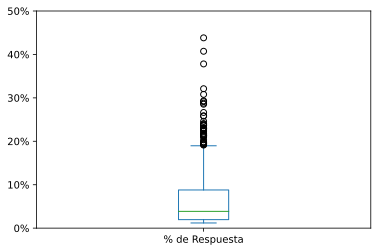

In [2]:
%config InlineBackend.figure_format = "svg"

pct_response = (ratings.iloc[:, 1:] != 0).mean(0)

ax = pct_response.plot.box()
ax.set_xticklabels(["% de Respuesta"])
ax.set_ylim(0, 0.5)
ax.set_yticks([num / 10 for num in range(6)])
ax.set_yticklabels([f"{num / 10:0.0%}" for num in range(6)]);

Justamente, uno de los grandes desafíos de los modelos de sistemas de recomendación, es realizar buenas predicciones en bases de datos donde el porcentaje de respuesta (o sea cuando el usuario asigna una calificación a un ítem) suele ser bastante bajo. En este caso, aproximadamente el 75% de los usuarios ha calificado solo el 10% de las películas disponibles.

Para asegurar la compatibilidad con la librería `surprise`, necesitamos pasar la data desde formato extenso a formato largo, usaremos el método `melt` que es el símil a la función `pivot_longer` del package `tidyr` de `R`. Así, obtendermos el trío `ítem`, `usuario`, `valoracion` en cada observación.

In [3]:
ratings_large = ratings.melt(id_vars="Movie", var_name="User", value_name="Rating")
ratings_large.head()

,Movie,User,Rating
0,Toy Story,U1,5
1,GoldenEye,U1,3
2,Four Rooms,U1,4
3,Get Shorty,U1,3
4,Copycat,U1,3


También necesitaremos aislar los datos con información observada (calificación mayor a 0) de la información no observada (igual a 0). Por exigencia de `valoración`, debemos dejar las columnas en el orden `usuario`, `ítem`, `valoración`, o sea que en cada fila debe ir una interacción.

In [4]:
ratings_obs   = ratings_large.query("Rating > 0")[["User", "Movie", "Rating"]]
ratings_unobs = ratings_large.query("Rating == 0")[["User", "Movie", "Rating"]]

print("Primeras Filas ratings observados:")
display(ratings_obs.head())
print("Primeras Filas ratings no observados:")
display(ratings_unobs.head())

Primeras Filas ratings observados:


,User,Movie,Rating
0,U1,Toy Story,5
1,U1,GoldenEye,3
2,U1,Four Rooms,4
3,U1,Get Shorty,3
4,U1,Copycat,3


Primeras Filas ratings no observados:


,User,Movie,Rating
272,U1,Heat,0
273,U1,Sabrina,0
274,U1,Sense and Sensibility,0
275,U1,Leaving Las Vegas,0
276,U1,Restoration,0


## Lectura de datos

Debido a que nos interesa comprobar el comportamiento de los modelos con recomendaciones futuras, separemos los datos observados en entrenamiento y testeo, con el fin de calcular métricas de desempeño en este último.

Luego de terminada la etapa de preprocesamiento de los datos, carguemos el `DataFrame` con las calificaciones observadas. Esto se lleva a cabo en conjunto con las clases `Dataset` y `Reader` de `surprise` (en la última debemos indicar valoración más baja y alta respectivamente).

In [5]:
# !pip install scikit-surprise
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader

train, test = train_test_split(ratings_obs, test_size=0.05, random_state=2022)

reader     = Reader(rating_scale=(1, 5)) # Ratings son del 1 al 5.
data_train = Dataset.load_from_df(df=train, reader=reader)

print("Primeras 10 observaciones almacenadas:")
data_train.raw_ratings[:10]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633984 sha256=217bc88a08ad8a508fbca26017156b1e99e66b931a8e07a4be809bed110de715
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
Primeras 10 observaciones almacenadas:


[('U664', 'Volcano', 2.0, None),
 ('U374', 'Set It Off', 3.0, None),
 ('U323', 'Grosse Pointe Blank', 3.0, None),
 ('U271', 'Ghost', 4.0, None),
 ('U561', 'M*A*S*H', 4.0, None),
 ('U292', 'Angels and Insects', 2.0, None),
 ('U931', 'Emma', 4.0, None),
 ('U256', 'Nick of Time', 4.0, None),
 ('U129', 'Wings of the Dove, The', 3.0, None),
 ('U303', 'Anaconda', 1.0, None)]

## Ajuste de modelos

Profundicemos en los detalles de los algoritmos que utilizaremos, veremos un ejemplo de modelos basados en memoria y otro de basados factorización de matrices. 

* Ambos modelos son **filtros colaborativos**, es decir, que se basan en utilizar interacciones pasadas en conjunto, para realizar una predicción. 
* Uno de los pricipales problemas de estos algoritmos es que no es posible realizar recomendaciones a un usuario nuevo, pues se requiere de re-entrenar el algoritmo usado en tal caso.
* El ajuste de estos modelos es bastante similar a como se haría en `scikit-learn`.

### Basados en memoria

<img src="https://www.researchgate.net/profile/Saleh-Alaliyat/publication/267953942/figure/fig14/AS:295388776026147@1447437580523/K-nearest-neighbor-algorithm-illustration-The-green-circle-is-the-sample-which-is-to-be.png" width="500">


* Se clasifican dentro de la familia **KNN** (*K-Nearest Neighbors*).
* Estos algoritmos calculan una matriz de similitud que puede ser entre usuarios (*user-based*) o entre ítems (*item-based*), luego se utilizan los $k$ usuarios o ítems más similares respectivamente (las interacciones involucradas fueron previamente memorizadas) para realizar una predicción de la calificación. 
* La matriz de similitud mencionada, debe construirse a partir de una métrica de similitud como lo son la `Correlación de Pearson` o la `Cos-similitud`.
* La interacción entre el usuario $u$ y el ítem $i$ utilizando el subconjunto $S$ de usuarios o ítems más cercanos, está dado por la fórmula:

$$
\hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in S}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v
\in S} \text{sim}(u, v)}
$$

Veamos su implementación, basada en usuarios y similitud coseno:

In [6]:
import surprise.prediction_algorithms.knns as knns

sim_options = {"name": "cosine", "user_based": True}

model_knn = knns.KNNWithZScore(sim_options=sim_options, verbose=False)
model_knn.fit(data_train.build_full_trainset())

**Medidas de similitud**

* En `surprice` contamos con cuatro opciones de medidas para calcular la similitud entre usuarios o ítems: `cosine`, `pearson`, `msd` y `pearson_baseline`. Sin embargo, solo son de interés las primeras dos.
* La similitud de `pearson`, como su nombre lo índica, es basada en el coeficiente de `pearson`, que hemos estudiado a lo largo del diplomado.
* La `cos`-similitud, es basada en las propiedades geométricas que tienen los vectores (interacciones de un usuario o ítem) en cuestión. Esta entrega el ángulo que forman dichos vectores evaluado en coseno. Para comprender la intuición de este valor, veamos la siguiente imágen.

<img src="https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg" width="800">

Como ejemplo, aprovechemos que el modelo KNN nos entrega la matriz de similitud con las configuraciones entregadas en la variable `sim_options` (cos-similitud y basada en usuarios).

In [7]:
users_sim = pd.DataFrame(
    data    = model_knn.sim, # Entrega una matriz simétrica.
    index   = ratings.columns[1:],
    columns = ratings.columns[1:]
)
users_sim.head()

,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,...,U934,U935,U936,U937,U938,U939,U940,U941,U942,U943
U1,1.000000,0.927618,0.968410,0.966108,0.958158,0.985857,0.962034,0.946025,0.893427,0.970961,...,0.979571,0.963739,1.000000,0.960114,0.890264,0.942965,1.000000,0.992798,0.943564,0.975178
U2,0.927618,1.000000,0.910028,0.915443,0.882008,0.944593,0.942039,0.942810,0.997054,0.911637,...,0.966244,0.976029,0.880771,0.961398,0.946077,0.927601,0.948644,0.897637,0.883620,0.705420
U3,0.968410,0.910028,1.000000,0.974877,0.953464,0.980402,0.939598,0.941467,0.832050,0.973837,...,0.953613,0.955287,0.952938,0.935063,0.957031,0.955096,0.943242,0.933587,0.978348,0.930353
U4,0.966108,0.915443,0.974877,1.000000,0.942863,0.966820,0.951024,0.941964,0.966695,0.959663,...,0.963789,0.980171,0.979635,0.969288,0.880271,0.942311,0.916278,0.949301,0.956929,0.909011
U5,0.958158,0.882008,0.953464,0.942863,1.000000,0.965391,0.978368,0.916504,0.950947,0.940340,...,0.982638,0.970495,0.999512,0.875570,0.949517,0.973248,0.989949,0.926393,0.950576,0.927555


Por ejemplo, ahora veamos los usuarios más y menos similares al Usuario 2:

In [8]:
print("- Usuarios más similares al Usuario 2:")
print(users_sim["U2"].sort_values(ascending=False).head())
print("\n- Usuarios menos similares al Usuario 2:")
print(users_sim["U2"].sort_values(ascending=True).head())

- Usuarios más similares al Usuario 2:
U766    1.0
U579    1.0
U735    1.0
U802    1.0
U908    1.0
Name: U2, dtype: float64

- Usuarios menos similares al Usuario 2:
U133    0.0
U823    0.0
U906    0.0
U715    0.0
U615    0.0
Name: U2, dtype: float64


### Factorización de matrices

* El objetivo de este tipo de algoritmos es encontrar factores latentes o no observados ( que carecen de interpretabilidad) para modelar las características propias de los usuarios e ítems, y en conjunto generar una predicción en la valoración.
* Usando los factores latentes, la predicción de la valoración dada la interacción entre el usuario $j$ e item $i$ se puede escribir como:
$$ 
\hat{y}^{(ij)} = \beta_j + \beta_i + \left( \theta^{(j)} \right)^\top x^{(i)}
$$
* Con esto, se busca que el error de predicción $J(\theta^{(1)}, \dots, \theta^{(n_u)})$, sea mínimo. Esta expresión esta dada por:
$$
J(\theta^{(1)}, \dots, \theta^{(n_u)}) = {1 \over 2} \sum_{j=1}^{n_u} \sum_{y^{(ij)} \text{ obs}} \left( y^{(ij)} - \hat{y}^{(ij)} \right)^2 + {\lambda \over 2} \sum_{j=1}^{n_u} \sum_{k=1}^{n_i} \left( \theta_k^{(j)} \right)^2
$$
* Parámetros:
    * $n_u$ y $n_i$: cantidad de usuarios y cantidad de ítems.
    * $\beta_j$ y $\beta_i$: sesgos para el usuario $j$ y usuario $i$ respectivamente.
    * $\theta^{(j)}$ y $x^{(i)}$: variables latentes asociadas al usuario $j$ e ítem $i$ respectivamente. 
    * $\lambda$: penalización.
* Como esta versión del error de predicción está escrita de forma poco conveniente para optimizar, se utiliza la versión matricial, lo que da origen a su nombre.
* Veremos el algoritmo *Negative Matrix Factorization* (NMF), en el cuál elegimos la cantidad de factores latentes: `n_factors`, cantidad de iteraciones que ejecuta el algortimo de optimización para encontrar el óptimo global: `n_epochs` e incluir sesgos para cada usuario e ítem: `biased`.

In [9]:
import surprise.prediction_algorithms.matrix_factorization as mf

model_nmf  = mf.NMF(
    n_factors    = 10,
    n_epochs     = 10,
    biased       = True,
    verbose      = False,
    random_state = 2022
)
model_nmf.fit(data_train.build_full_trainset())

* Los vectores asociados a los interceptos de usuarios e ítems se encuentran almacenados en las propiedades `bu` y `bi` respectivamente.
* Los vectores asociados a las variables latentes $\theta^{(u)}$ y $x^{(i)}$ se encuentran almacenados en las propiedades `pu` y `qi` respectivamente.

In [10]:
print("Factores latentes de los primeros 5 usuarios:")
display(
    pd.DataFrame(
        data  = model_nmf.pu,
        index = ratings.columns[1:],
        columns = [f"FL{num + 1}" for num in range(10)]
    ).head()
)

Factores latentes de los primeros 5 usuarios:


,FL1,FL2,FL3,FL4,FL5,FL6,FL7,FL8,FL9,FL10
U1,0.008646,0.357676,0.127083,0.044565,0.419709,0.337082,0.615026,0.487314,0.559940,0.433868
U2,0.703254,0.518854,0.558466,0.565814,0.255143,0.332448,0.242591,0.438642,0.559922,0.070455
U3,0.455556,0.219079,0.220068,0.386210,0.014156,0.373561,0.627672,0.282620,0.169422,0.282392
U4,0.391207,0.265149,0.601371,0.040312,0.586694,0.298004,0.528823,0.603301,0.282472,0.646322
U5,0.076066,0.039008,0.255357,0.287861,0.331181,0.408279,0.447660,0.359227,0.074272,0.538989


In [11]:
print("Factores latentes de las primeras 5 películas:")
display(
    pd.DataFrame(
        data    = model_nmf.qi,
        index   = train["Movie"].unique(),
        columns = [f"FL{num + 1}" for num in range(10)]
    ).head()
)

Factores latentes de las primeras 5 películas:


,FL1,FL2,FL3,FL4,FL5,FL6,FL7,FL8,FL9,FL10
Volcano,0.005919,0.288830,0.015142,0.356652,0.404937,0.368670,0.247201,0.391578,0.102860,0.247805
Set It Off,0.263156,0.319268,0.188971,0.234882,0.152161,0.034941,0.489127,0.118689,0.073616,0.455008
Grosse Pointe Blank,0.151710,0.278844,0.015598,0.440266,0.546117,0.579250,0.030297,0.502357,0.045416,0.637240
Ghost,0.593189,0.280722,0.459977,0.391790,0.326222,0.307000,0.217198,0.348925,0.483675,0.420965
M*A*S*H,0.614919,0.441732,0.482778,0.359488,0.618495,0.317162,0.059778,0.328800,0.501642,0.096259


## Predicciones

* Una vez que hemos ajustado los modelos, es super directo realizar una predicción de la valoración que le da el usuario `uid` al ítem `iid`. 
* Lo llevaremos a cabo con el método `predict` igual que en `scikit-learn`.
* Se puede acceder al valor predicho a través de la propiedad `est`.
* Por ejemplo: Veamos la calificación predicha por ambos modelos entrenados, del usuario `U529` a la película "I Know What You Did Last Summer", que es la primera observación del set de testeo.

In [12]:
prediccion_knn = model_knn.predict(uid="U529", iid="I Know What You Did Last Summer")
prediccion_nmf = model_nmf.predict(uid="U529", iid="I Know What You Did Last Summer")
print("Calificación predicha con KNN:", prediccion_knn.est)
print("Calificación predicha con NMF:", prediccion_nmf.est)
print("Calificación real:", test.iloc[0, 2])

Calificación predicha con KNN: 3.2552722957960514
Calificación predicha con NMF: 3.365812324030773
Calificación real: 4


Nuestro interés puede estar en realizar muchas predicciones de una sola vez, por lo que definiremos una función que calcule la predicción y luego con el método `apply` de los `DataFrame` de `pandas` realizaremos la predicción de cada interacción.

In [13]:
def prediccion_rating(modelo, usuario, item):
    prediccion = modelo.predict(uid=usuario, iid=item)
    return prediccion.est

In [14]:
# Para KNN
test["KNNPrediction"] = test.apply(
    func = lambda df: prediccion_rating(model_knn, df["User"], df["Movie"]),
    axis = 1
)
# Para NMF
test["NMFPrediction"] = test.apply(
    func = lambda df: prediccion_rating(model_nmf, df["User"], df["Movie"]),
    axis = 1
)
test.head()

,User,Movie,Rating,KNNPrediction,NMFPrediction
888777,U529,I Know What You Did Last Summer,4,3.255272,3.365812
1097709,U653,Malice,1,2.437639,2.403259
1088321,U648,"Crow, The",1,3.243878,3.340375
720522,U429,Robin Hood: Prince of Thieves,2,2.953822,3.016690
276069,U165,Star Trek: First Contact,5,4.160976,3.750377


Aprovechemos estas predicciones para calcular el *RMSE* en el set de testeo.

In [15]:
from sklearn.metrics import mean_squared_error

rmse_knn = mean_squared_error(test["Rating"], test["KNNPrediction"], squared=False)
rmse_nmf = mean_squared_error(test["Rating"], test["NMFPrediction"], squared=False)

print("RMSE modelo KNN:", rmse_knn)
print("RMSE modelo NMF:", rmse_nmf)

RMSE modelo KNN: 0.9732125605222871
RMSE modelo NMF: 1.2062986493941301


## Validación cruzada

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstatic.platzi.com%2Fmedia%2Fuser_upload%2Fcross_validation-f384cbbd-b41e-48d3-aa8a-97cfb95993c5.jpg&f=1&nofb=1" width="800">


* Recordemos que el objetivo de la validación cruzada, es obtener una medida de desempeño más robusta que la obtenida directamente del set de entrenamiento, ya que el modelo puede estar sufriendo de *overfitting* o *underfitting*.
* En este caso usaremos la estrategia de validación cruzada *5-Folds*, que consiste en separar el set de entrenamiento en 5 subconjuntos aleatorios de datos.
* Para configurar esta estrategia, está disponible la clase `KFold` del módulo `model_selection` de la librería `surprise`.
* Luego, la función `cross_validate` de mismo origen que la clase `KFold`, realiza la validación cruzada. Esta recibe argumentos similares que la función `cross_val_score` de `scikit-learn` que ya estudiamos.

In [16]:
from surprise.model_selection import KFold, cross_validate

kfold = KFold(n_splits=5, shuffle=True, random_state=2022)

print("", end="- ")
model_knn_cv = cross_validate(
    algo     = model_knn,
    data     = data_train,
    measures = ["rmse"],
    cv       = kfold,
    n_jobs   = -1,
    verbose  = True
)
print("", end="\n- ")
model_nmf_cv = cross_validate(
    algo     = model_nmf,
    data     = data_train,
    measures = ["rmse"],
    cv       = kfold,
    n_jobs   = -1,
    verbose  = True
)

- Evaluating RMSE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9474  0.9603  0.9535  0.9542  0.9597  0.9550  0.0047  
Fit time          2.36    1.74    1.95    1.67    1.01    1.74    0.44    
Test time         7.53    4.99    4.88    4.53    2.37    4.86    1.64    

- Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9354  0.9510  0.9495  0.9431  0.9533  0.9464  0.0065  
Fit time          1.30    1.34    1.35    1.37    0.65    1.20    0.27    
Test time         0.23    0.21    0.24    0.23    0.13    0.21    0.04    


De esta forma, ya obtenemos una mejor panorámica del funcionamiento de ambos modelos, vista en una tabla que indica los resultados en cada etapa con una media y desviación estándar global.

## Optimización y búsqueda de hiperparámetros

Los algorimtos que hemos estado usando durante esta clase tienen una serie de hiperparámetros a ajustar. Por ejemplo, en el caso del modelo KNN podemos ajustar:

* `k`: La cantidad de vecinos (usuarios o ítems) a usar para realizar el cálculo de la valoracion.
* `min_k`: Cantidad mínima de vecinos a usar, en el caso de que no existan vecinos con las caracteristicas o información necesaria para calcular la valoración.
* `sim_options`: Diccionario con las configuraciones en el cálculo de la similitud entre usarios o ítems.
  * `user_based`: El cálculo de la valoracion de un ítem puede estar dado en base a ítems similares, o en base a usuarios similares que han valorado el ítem.
  * `name`: Medida de similitud usada, por ejemplo: `pearson` o `cosine`.

Estos hiperparámetros debemos almacenarlos previamente en un diccionario, para luego entregarselos a la clase `GridSearchCV` del módulo `model_selection` de `surprise`. La principal diferencia con la implementación de `scikit-learn`, es que debemos entregar directamente la clase del modelo y no una instancia de este.

In [17]:
%%time
from surprise.model_selection import GridSearchCV

knn_hp = {
    "k" : [10, 30, 50],
    "min_k": [1, 5],
    "sim_options": {
        "user_based": [True, False],
        "name": ["pearson", "cosine"]
    } 
}

models = GridSearchCV(
    algo_class = knns.KNNWithZScore,
    param_grid = knn_hp,
    measures   = ["rmse"],
    cv         = kfold,
    n_jobs     = -1
)
models.fit(data_train)

CPU times: user 4min 38s, sys: 1.11 s, total: 4min 39s
Wall time: 9min 9s


Los resultados finales están almacenados en distintas propiedades luego de la búsqueda de hiperparámetros:
* `best_params`: La combinación de hiperparámetros que consigue que la métrica de interés sea mínima.
* `best_score`: La métrica obtenida en la mejor combinación de hiperparámetros.
* `best_estimator`: El mejor modelo obtenido en base a los hiperparámetros que minimizan la métrica de desempeño. Es necesario volver a ajustar con el método `fit`.

In [18]:
print("Mejor RMSE:", models.best_score["rmse"])
print("Mejores hiperparámetros:", models.best_params["rmse"])

Mejor RMSE: 0.941103420675389
Mejores hiperparámetros: {'k': 50, 'min_k': 1, 'sim_options': {'user_based': False, 'name': 'pearson'}}


Ajustemos el mejor modelo obtenido:

In [19]:
best_knn = models.best_estimator["rmse"].fit(data_train.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


Lo que sigue, es calcular las valoraciones predichas con este modelo, y comparar su RMSE con los modelos iniciales.

In [20]:
test["BestModelPrediction"] = test.apply(
    func = lambda df: prediccion_rating(best_knn, df["User"], df["Movie"]),
    axis = 1
)

rmse_best_model = mean_squared_error(test["Rating"], test["BestModelPrediction"], squared=False)

print("RMSE modelo KNN:", rmse_knn)
print("RMSE modelo NMF:", rmse_nmf)
print("RMSE Mejor modelo:", rmse_best_model)

RMSE modelo KNN: 0.9732125605222871
RMSE modelo NMF: 1.2062986493941301
RMSE Mejor modelo: 0.9475724665370915


Recordemos que para decidir que tan bueno es un ajuste, no solo debemos considerar la métrica obtenida, también debemos estudiar los costos y ganancias que producen las predicciones dadas.

Para finalizar, volvamos al origen del problema que es predecir la valoración de las interacciones no observadas.

In [21]:
%%time
ratings_unobs["Prediction"] = ratings_unobs.apply(
    func = lambda df: prediccion_rating(best_knn, df["User"], df["Movie"]),
    axis = 1
)

CPU times: user 3min, sys: 677 ms, total: 3min 1s
Wall time: 3min 1s


Por ejemplo, veamos las películas que obtendrían las mejores calificaciones por el Usuario 2. Estas podrían ser eventualmente las recomendaciones que le mostraríamos al usuario.

In [22]:
ratings_unobs.query("User == 'U2'").sort_values("Prediction", ascending=False).head(20)

,User,Movie,Rating,Prediction
2974,U2,Star Kid,0,5.000000
3148,U2,"Saint of Fort Washington, The",0,5.000000
2785,U2,C'est arriv� pr�s de chez vous,0,5.000000
3217,U2,Aiqing wansui,0,5.000000
2495,U2,"Great Day in Harlem, A",0,5.000000
2803,U2,They Made Me a Criminal,0,5.000000
2870,U2,Prefontaine,0,5.000000
3334,U2,Entertaining Angels: The Dorothy Day Story,0,5.000000
3280,U2,Someone Else's America,0,5.000000
3337,U2,Little City,0,5.000000


Este es el final del curso de **Herramientas de Machine Learning en Python** ¡Esperamos que les haya gustado!

---

## Ejercicios de práctica

Amazon es una tienda tecnológica estadounidense que en sus comienzos era solo un sitio web de venta de libros. En la actualidad sus focos están en el comercio web, computación en la nube, servicios de streaming e inteligencia artificial. Este último les ha permitido desarrollar uno de los sistemas de recomendación más reconocidos a nivel mundial. 

Con la autorización de esta empresa y a través de técnicas de web scraping, se ha logrado obtener un gran volumen de datos para fines de investigación y desarrollo de nuevas técnicas de recomendación a usuarios.

La base de datos `reviews.parquet` contiene información de algunas reseñas relacionadas con accesorios de teléfonos entre 2002 y 2018. Las variables disponibles en esta data son:

* `overall`: Calificación en escala del 1 al 5 del producto asociado.
* `reviewTime`: Fecha de publicación de la reseña.
* `reviewerID`: ID de persona que publicó la reseña. Ejemplo: <https://www.amazon.com/gp/cdp/member-reviews/A24E3SXTC62LJI>.
* `asin`: ID del producto. Ejemplo: <https://www.amazon.com/dp/7508492919>.
* `summary`: Título de la reseña.

El objetivo de este ejercicio es desarrollar un sistema recomendador que permita ofrecerles productos que podrían gustarle a las personas, con el fin de aumentar las ventas.

In [23]:
import pandas as pd

reviews = pd.read_parquet("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/reviews.parquet")
reviews.head()

,overall,reviewTime,reviewerID,asin,summary
0,5.0,2014-08-04,A24E3SXTC62LJI,7508492919,Can't stop won't stop looking at it
1,5.0,2014-02-12,A269FLZCB4GIPV,7508492919,1
2,3.0,2014-02-08,AB6CHQWHZW4TV,7508492919,Its okay
3,2.0,2014-02-04,A1M117A53LEI8,7508492919,CASE
4,4.0,2014-02-03,A272DUT8M88ZS8,7508492919,Cute!


**1.** Cargue los datos adjuntos en el bloque anterior ¿cuantos usuarios hay disponibles? ¿cúantos artículos hay disponibles? Con esa información calcule la cantidad de artículos sin calificar por parte de los usuarios.

In [24]:
# Responda aquí:


**2.** Verifique la cantidad de reseñas por usuario. Luego realice un boxplot de esto último. ¿Es factible realizar recomendaciones a usuarios con una baja cantidad de reseñas? Mencione posibles acciones a seguir.

In [25]:
# Responda aquí:


**3.** Separe los datos en un 95% de entrenamiento y 5% testeo. Traspase los datos de entrenamiento a un formato reconocible para `surprice` (recuerde que esto se hace con las clases `Dataset` y `Reader`).

In [26]:
# Responda aquí:


**4.** Implemente el algoritmo `NMF` con los parámetros que incluye por defecto. Ajuste el modelo y obtenga los resultados del *Mean Absolute Error* (`measures=["mae"]`) en validación cruzada con estrategia 3-Folds. (Considere un tiempo de ejecución de un minuto aproximadamente).

In [27]:
# Responda aquí:


**5.** Optimize los hiperparámetros del modelo con el fin de maximizar el MAE. A continuación se le sugiere una grilla a usar:

```python
import numpy as np

nmf_hp = {
    "n_factors": [5, 25],
    "n_epochs" : [20, 50],
    "biased"   : [True, False]
}
```

In [28]:
# Responda aquí:


**6.** Muestre los mejores hiperparámetros encontrados en el paso anterior. ¿Hay una mejora significativa en el MAE? Si es así, ajuste el mejor modelo encontrado bajo este criterio.

In [29]:
# Responda aquí:


**7.** Realice predicciones respecto a las 5 primeras reseñas que están disponibles en el set de testeo. ¿Estas son similares a las calificaciones reales?

In [30]:
# Responda aquí:
